4.188790204786391e-09
['/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case', '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00001_case']
['/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case', '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00001_case']
['/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case', '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00001_case']
['/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case/postProcessing/surfaces/', '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00001_case/postProcessing/surfaces/']
['/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case/postProcessing/height.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreading

FileNotFoundError: [Errno 2] No such file or directory: '/home/asghar/Downloads/wettingTestCases/argoCases/SphericalSpreadingTest/test_00000_case/postProcessing/height.csv'

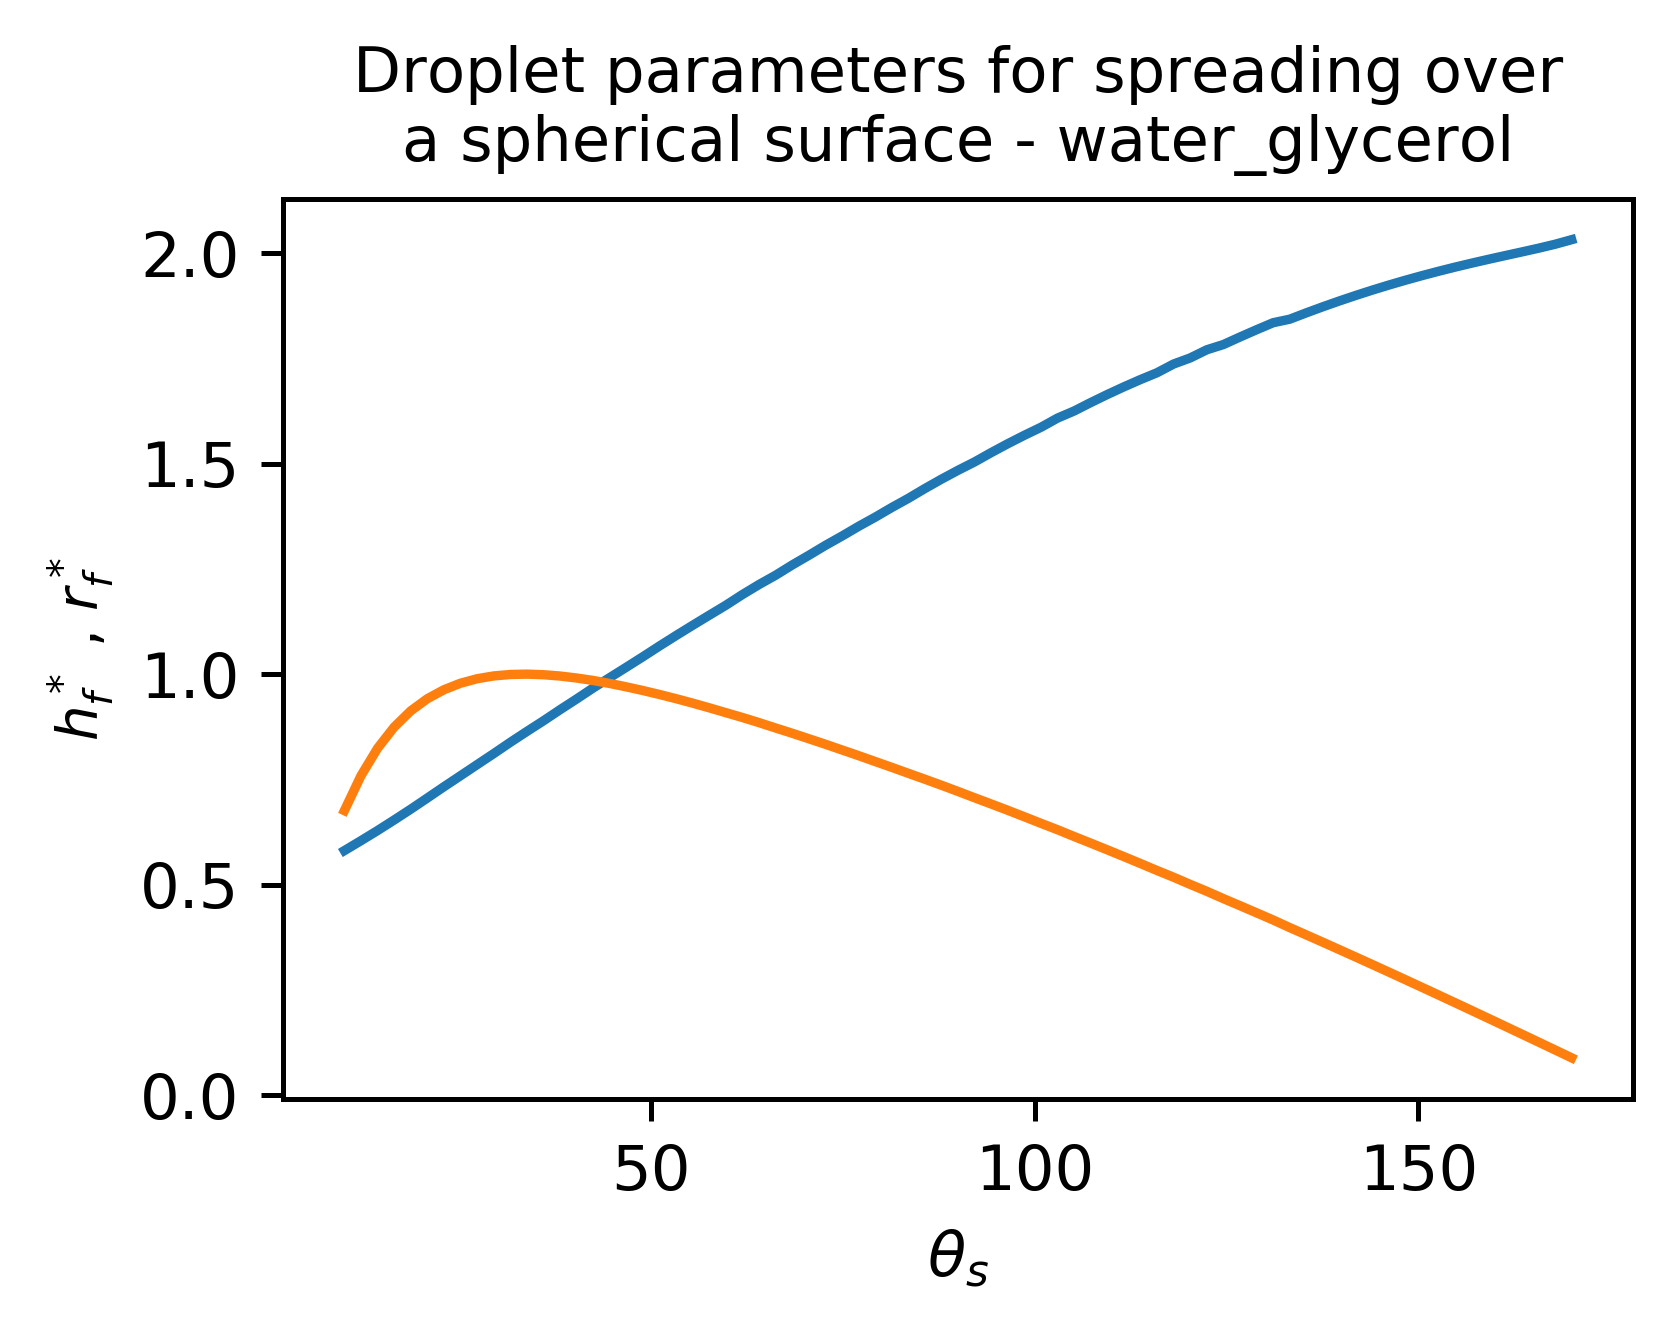

In [5]:
#Assumptions: 
#1.  z-axis is the height of the domain. 
#2.  if geometry chnages, change the height of the sphere for droplet height calculations 

import numpy as np
from scipy.optimize import fsolve
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import csv
import vtk
###################################################################################################################

sin =np.sin
cos= np.cos
pi = np.pi

#Degree range (x-axis)
thetaDeg =np.linspace(10, 170, 75) 
R0 = 0.001
V = 4/3*pi*R0**3
print(V)
eps = 1e-10
heightOfSphere = 0.001675

###################################################################################################################

def getdeltaV(a, b, V):
    return math.fabs(V-get_V(a, b))

def get_V(a, b):
    return (pi/3*(R0*sin(a)/sin(b))**(3) * (1+cos(b))**(2) *(2-cos(b))) \
           +(pi/3*R0**(3) * (1+cos(a))**(2) *(2-cos(a))) \
           -(4/3*pi*R0**3) 

def getAngles(thetaDeg):
    thetaDeg = 180-thetaDeg
    a, b = np.radians(thetaDeg/2), np.radians(thetaDeg/2)

    isNewLess = False
    isNewLessPrev = False
    if(get_V(a, b) < V):
        isNewLess = True
        isNewLessPrev = True

    count =0
    boolSub = True
    deltaV = getdeltaV(a, b, V)
    deltaVPrev = deltaV

    while (isNewLess == isNewLessPrev ):
        #print(math.fabs(get_V(a, b)))
        if(count ==0):
            count+=0.1
            a, b = np.radians(((thetaDeg-count)/2) ), np.radians(((thetaDeg+count)/2))
            deltaV = getdeltaV(a, b, V)
            if (deltaV<deltaVPrev):
                boolSub = True
            else:
                boolSub = False
            continue

        deltaV = getdeltaV(a, b, V)
        #check for Delta_V 
        if (boolSub): #getting closer to the solution -> continue decreasing a and increasing b 
            a, b = np.radians(((thetaDeg-count)/2)), np.radians(((thetaDeg+count)/2))
            deltaVPrev =deltaV
        else:
            a, b = np.radians(((thetaDeg+count)/2)), np.radians(((thetaDeg-count)/2))
            deltaVPrev =deltaV
            
        if(get_V(a, b) < V):
            isNewLess = True
        elif(get_V(a, b) > V):
            isNewLess = False
        count+=0.1
        
    hf= ((R0*sin(a)/sin(b)*(1+cos(b))) - (R0*(1-cos(a))))/R0
    rf = sin(a)
    return hf, rf, (rf/sin(b))

###################################################################################################################

hf = [getAngles(val)[0] for idx, val in enumerate(thetaDeg)]
rf = [getAngles(val)[1] for idx, val in enumerate(thetaDeg)]

###################################################################################################################
## File structure (absolute working driectory)
def fileStructure(dataFile):
    #File structure
    pattern = "test_"
    dataFolder = "/postProcessing/"
    dataFile = dataFile
    cwd = os.getcwd()
    casefolders = [cwd + "/" + folder for folder in os.listdir(cwd) if pattern in folder]
    print(casefolders)
    
    datafolders = [df+dataFolder for df in casefolders]
    datafolders.sort()
    fileNames = [fN+dataFile for fN in datafolders]
    return(fileNames)    

##################################################################################################################
class height_vector:
    x_coord = 0.0
    y_coord = 0.0
    z_coord = 0.0  

vtk_folders = fileStructure('surfaces/')
heightFileNames =  fileStructure('height.csv')
rfMaxFileNames =  fileStructure('rfMax.csv')
#fileStructure('surfaces/')
print(vtk_folders)
print(heightFileNames)
print(rfMaxFileNames)

##################################################################################################################
# Height of the droplet at a specific time step Plots
#location of vtk files
def writeHeightFile(calcHeights):
    if(calcHeights):
        for idx, vtk_folder in enumerate(vtk_folders):
            #getting the time step folder names
            sub_folders = [name for name in os.listdir(vtk_folder) if os.path.isdir(os.path.join(vtk_folder, name))]
            sub_folders.sort()
            numberOfCoordinates = 0.0
            ifCoordArray = 0 # just to take POINTS array
            heightObject = height_vector()
            counter =0

            #file-content
           # header = ['Time(s)', 'Height(m)']
            with open(heightFileNames[idx], 'w') as f:
                writer = csv.writer(f)

            for sub_folder in sub_folders:
                heightObject.z_coord = 0
                with open(vtk_folder + sub_folder +"/isoAlpha.vtk") as reader:
                    for line in reader:
                        if "POINTS" in line: #start of coordinates
                            #print(line, end='')
                            breakUp = line.split()
                            numberOfCoordinates = int(breakUp[1])
                            ifCoordArray = 1;

                        if "\n" not in line[0] and ifCoordArray ==1 and "POINTS" not in line:
                            coordBreakUp = line.split()

                            if (counter ==0):
                                heightObject.z_coord = float (coordBreakUp[2])
                                counter =1
                            else:
                            #check on Z coordinate
                                if (len(coordBreakUp)>3):
                                    heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[2]))
                                    heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[5]))
                                else:
                                    heightObject.z_coord = max (heightObject.z_coord, float(coordBreakUp[2]))

                        if "\n" in line[0] and ifCoordArray ==1:
                            ifCoordArray =2

                data_to_write_to_csv = [sub_folder, str(heightObject.z_coord)]

                with open(heightFileNames[idx], 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(data_to_write_to_csv)

###############################################################################################################
calcHeights = False
writeHeightFile(calcHeights)
plotLabels = [r"numerical height", r"numerical contact radius"]

#Plot equilibrium spread against static contact angle
fig = plt.figure()
myaxes = fig.add_axes([0.1, 0.1, 0.5, 0.5])
rcParams["figure.dpi"] = 450
plt.plot(thetaDeg, hf, label=r'$hf^*$')
plt.plot(thetaDeg, rf, label=r'$rf^*$')
plt.title(r'Droplet parameters for spreading over'+'\n' +r'a spherical surface - water_glycerol', fontsize=10)
plt.xlabel(r'$\theta_s$' ,color='black',fontsize=10)
plt.ylabel(r'$h_f^*$ , $r_f^*$',color='black',fontsize=9)

simStaticCAList=[30, 60, 90, 120, 150] #contact angles for the simulaitons
equilibriumhfList= [None] *len(simStaticCAList)

nPointsForHeightAverage = 2
for idx, heightFile in enumerate(heightFileNames):
    avgHeight = 0
    for i in range(1, nPointsForHeightAverage):
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-i]
            avgHeight += (float(last_line.rsplit(',', 1)[1]) - heightOfSphere)

    avgHeight /= (nPointsForHeightAverage-1)
    equilibriumhfList[idx] = (avgHeight /R0 ) 

plt.plot(simStaticCAList, equilibriumhfList, marker='s', markerfacecolor='None',linestyle = 'None', label=plotLabels[0])
#######################################################################################
equilibriumrfList= [None] *len(simStaticCAList)

for idx, rfFile in enumerate(rfMaxFileNames):
        with open(rfMaxFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            print(last_line.rsplit(',', 1)[1])
            equilibriumrfList[idx] =(float(last_line.rsplit(',', 1)[1])/R0)

plt.plot(simStaticCAList, equilibriumrfList,
            marker='s',
            markerfacecolor='None',
            linestyle = 'None', label=plotLabels[1])
##############################################################################

plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.33, 0), ncol=2)
plt.savefig('plots/spherical-droplet-spreading-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
plt.show()